# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: Precision at 20% Recall.

#### Business problem




#### Notes:

One big question about this data is which features are available at the origination time and are never updated afterwards. It seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.
I will use only features, known before loan issuance.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [72]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [125]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries', 'total_rec_prncp', 'total_rec_int']

df = df[features_tokeep]

recoveries = df[df.loan_status.isin(['Charged Off', 'Default'])][[
    'id', 'loan_status', 'recoveries', 'loan_amnt', 'int_rate', 'total_rec_prncp', 'total_rec_int']]

df.drop(columns = ['recoveries', 'total_rec_prncp', 'total_rec_int'], inplace=True)
# this removes all features, not known to investors ex ante.

df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
#df = df.sample(200000, random_state=1)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 68)

1.6907405853271484

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,143271683,Current,19000.0,19000.0,19000.0,36.0,7.02,586.840027,2018-11-01,credit_card,Credit card refinancing,w,Individual,A,A2,674.0,Manager,10+ years,MORTGAGE,81000.0,074xx,NJ,16.889999,Source Verified,6.0,28.0,33.0,NaN,NaN,NaN,3.0,Mar-2012,0.0,1.0,7.0,12.0,8.0,0.0,16.0,3877.0,46519.0,17103.0,49.4,13797.0,6.0,6.0,10.0,34600.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,46519.0,0.0,0.0,25.000000,93.300003,2.0,1.0,0.0,0.0,0.0,1.0,2018.0
1,134737786,Current,11000.0,11000.0,11000.0,60.0,19.42,287.899994,2018-06-01,major_purchase,Major purchase,w,Individual,D,D3,704.0,HTA-1,< 1 year,RENT,80000.0,410xx,KY,30.080000,Not Verified,17.0,NaN,NaN,NaN,NaN,NaN,0.0,Sep-2004,2.0,5.0,5.0,9.0,2.0,2.0,15.0,6531.0,52244.0,20619.0,54.1,17305.0,34.0,4.0,5.0,38100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,52244.0,0.0,0.0,66.699997,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0
2,40694622,Fully Paid,6075.0,6075.0,6075.0,36.0,16.99,216.570007,2015-02-01,home_improvement,Home improvement,f,Individual,D,D3,664.0,Project Manager,4 years,MORTGAGE,60000.0,480xx,MI,19.660000,Not Verified,4.0,41.0,41.0,NaN,NaN,NaN,1.0,Jul-2002,1.0,NaN,NaN,7.0,2.0,1.0,12.0,55823.0,334935.0,2881.0,75.8,919.0,4.0,2.0,3.0,3800.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,85959.0,100.0,0.0,50.000000,91.699997,NaN,NaN,0.0,0.0,0.0,1.0,2015.0
3,161640318,Current,4500.0,4500.0,4500.0,36.0,13.08,151.800003,2019-11-01,credit_card,Credit card refinancing,w,Individual,B,B5,674.0,Medical assistant,8 years,RENT,41600.0,107xx,NY,20.080000,Not Verified,3.0,29.0,29.0,NaN,NaN,NaN,4.0,Feb-2007,2.0,5.0,7.0,12.0,5.0,0.0,20.0,6580.0,78962.0,6622.0,41.4,5578.0,3.0,8.0,9.0,16000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,78962.0,0.0,0.0,0.000000,70.000000,3.0,1.0,0.0,0.0,0.0,6.0,2019.0
4,162272547,Fully Paid,13000.0,13000.0,13000.0,36.0,8.19,408.519989,2019-11-01,small_business,Business,w,Individual,A,A4,734.0,Project Manager,3 years,MORTGAGE,75000.0,234xx,VA,12.320000,Source Verified,4.0,NaN,NaN,103.0,NaN,NaN,1.0,Oct-1999,1.0,0.0,1.0,10.0,2.0,1.0,41.0,26783.0,267826.0,3795.0,10.9,30405.0,4.0,2.0,7.0,34900.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,115113.0,0.0,0.0,16.700001,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2019.0


## 3. Data preprocessing

In [74]:
### feature description:

#f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
#f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
#display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

In [75]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [76]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,147963558,Current,34000.0,34000.0,34000.0,60.0,17.19,848.469971,2019-02-01,home_improvement,Home improvement,w,Individual,C,C5,719.0,Case Manager,5 years,OWN,76000.0,331xx,FL,13.450000,Source Verified,1.0,78.0,78.0,69.0,NaN,NaN,9.0,2008-09-01,0.0,2.0,3.0,29.0,16.0,0.0,37.0,1683.0,48819.0,9926.0,13.5,32392.0,1.0,6.0,27.0,73500.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,48819.0,0.0,0.0,0.0,89.199997,8.0,1.0,0.0,0.0,0.0,4.0,2019.0,2,2019,10.417736,0.095990
1,141559688,In Grace Period,30000.0,30000.0,30000.0,36.0,17.97,1084.130005,2018-10-01,major_purchase,Major purchase,w,Individual,D,D1,699.0,RN,2 years,RENT,82000.0,210xx,MD,11.470000,Source Verified,6.0,28.0,28.0,NaN,NaN,NaN,1.0,2013-05-01,0.0,1.0,1.0,9.0,9.0,0.0,11.0,4076.0,36688.0,1571.0,18.3,7029.0,6.0,5.0,7.0,8600.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,36688.0,0.0,0.0,14.3,90.900002,1.0,0.0,0.0,0.0,0.0,1.0,2018.0,10,2018,5.418318,0.000000
2,142124855,Current,30000.0,30000.0,30000.0,36.0,19.92,1113.689941,2018-10-01,debt_consolidation,Debt consolidation,w,Individual,D,D3,704.0,NaN,NaN,RENT,90000.0,591xx,MT,22.690001,Verified,3.0,NaN,NaN,NaN,NaN,NaN,1.0,1983-10-01,0.0,2.0,1.0,9.0,3.0,3.0,22.0,5228.0,41827.0,28492.0,71.6,1501.0,3.0,5.0,8.0,39800.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,41827.0,0.0,0.0,100.0,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2018.0,10,2018,35.001403,0.000000
3,63496547,Fully Paid,20000.0,20000.0,19900.0,36.0,12.69,670.900024,2015-10-01,home_improvement,Home improvement,f,Individual,C,C2,699.0,Sr. Principal Design Engineer,10+ years,MORTGAGE,130000.0,921xx,CA,9.000000,Source Verified,3.0,16.0,NaN,NaN,16.0,16.0,4.0,1987-04-01,0.0,NaN,NaN,16.0,4.0,3.0,35.0,62927.0,880976.0,128768.0,47.5,17935.0,3.0,7.0,14.0,189400.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,128768.0,0.0,0.0,50.0,91.199997,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,10,2015,28.501612,0.000000
4,162321222,Current,4800.0,4800.0,4800.0,36.0,7.56,149.449997,2019-11-01,debt_consolidation,Debt consolidation,f,Individual,A,A3,694.0,NaN,< 1 year,RENT,30000.0,857xx,AZ,34.000000,Not Verified,2.0,64.0,64.0,62.0,NaN,64.0,4.0,1999-03-01,0.0,1.0,1.0,13.0,7.0,2.0,42.0,1887.0,24526.0,2355.0,6.2,10874.0,2.0,5.0,11.0,37800.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,24526.0,0.0,0.0,0.0,94.300003,3.0,1.0,0.0,0.0,0.0,2.0,2019.0,11,2019,20.671198,0.048376


In [77]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             98934
Current                                                72592
Charged Off                                            25688
Late (31-120 days)                                      1156
In Grace Period                                          748
Late (16-30 days)                                        199
Issued                                                   152
Does not meet the credit policy. Status:Fully Paid       147
Does not meet the credit policy. Status:Charged Off       47
Default                                                   25
Name: loan_status, dtype: int64

(124647, 73)

Fully Paid                                             98934
Charged Off                                            25688
Default                                                   25
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

id                                124647
loan_status                       124647
loan_amnt                         124647
funded_amnt                       124647
funded_amnt_inv                   124647
term                              124647
int_rate                          124647
installment                       124647
issue_d                           124647
purpose                           124647
title                             123232
initial_list_status               124647
application_type                  124647
grade                             124647
sub_grade                         124647
fico_range_high                   124647
emp_title                         116004
emp_length                        116912
home_ownership                    124647
annual_inc                        124647
zip_code                          124647
addr_state                        124647
dti                               124574
verification_status               124647
mo_sin_rcnt_tl  

85.94425296783447

### 3. Feature Preprocessing

In [78]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    40976
2.0     11301
0.0     10305
3.0      9923
1.0      8173
5.0      7931
4.0      7574
6.0      5763
8.0      5296
7.0      5121
9.0      4549
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
3,63496547,20000.0,20000.0,19900.0,36.0,12.69,670.900024,home_improvement,Home improvement,f,Individual,C,C2,699.0,Sr. Principal Design Engineer,10.0,MORTGAGE,130000.0,921,CA,9.000000,Source Verified,3.0,16.0,NaN,NaN,16.0,16.0,4.0,0.0,NaN,NaN,16.0,4.0,3.0,35.0,62927.0,880976.0,128768.0,47.5,17935.0,3.0,7.0,14.0,189400.0,2.0,0.0,0.0,0.0,0.0,128768.0,0.0,0.0,50.0,91.199997,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,10,2015,28.501612,0.0,0.0,0.153846,0.061929,0,0.990523,0.484054,6.776739,0.990523,1.456923,0,0.457143,0
5,778424,5000.0,5000.0,5000.0,36.0,12.99,168.449997,debt_consolidation,Debt Consolidation Loan,f,Individual,C,C1,709.0,Lowes,2.0,RENT,28000.0,342,FL,18.639999,Verified,NaN,69.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,22.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,6,2011,11.833234,0.0,0.0,0.178571,0.072193,0,0.000000,NaN,NaN,NaN,NaN,0,0.181818,0
7,6738557,20000.0,20000.0,20000.0,36.0,20.31,746.440002,debt_consolidation,Debt Consolidatoin,f,Individual,D,D5,674.0,Dell Government Services,5.0,MORTGAGE,70000.0,300,GA,17.969999,Source Verified,3.0,80.0,NaN,NaN,80.0,80.0,2.0,2.0,NaN,NaN,21.0,5.0,2.0,41.0,12286.0,159712.0,16701.0,75.6,606.0,3.0,7.0,8.0,22087.0,0.0,0.0,0.0,0.0,0.0,50652.0,0.0,0.0,100.0,97.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,8,2013,11.915371,0.0,0.0,0.285714,0.127961,0,0.238586,0.175514,2.281600,0.723600,0.315529,0,0.512195,0
8,2094203,6750.0,6750.0,6750.0,36.0,6.62,207.250000,debt_consolidation,credit card loan,f,Individual,A,A2,739.0,AXA,4.0,MORTGAGE,150000.0,900,CA,3.510000,Not Verified,0.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,8.0,6.0,1.0,11.0,41672.0,291702.0,5639.0,35.2,10361.0,0.0,1.0,6.0,16000.0,0.0,0.0,0.0,0.0,0.0,9321.0,0.0,0.0,0.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2012.0,11,2012,6.338255,0.0,0.0,0.045000,0.016580,0,0.037593,0.277813,1.944680,0.062140,0.106667,0,0.727273,0
10,91685636,28200.0,28200.0,28200.0,60.0,18.99,731.369995,major_purchase,Major purchase,f,Individual,D,D3,734.0,NaN,NaN,MORTGAGE,95000.0,214,MD,18.059999,Verified,3.0,78.0,78.0,NaN,78.0,78.0,6.0,1.0,1.0,4.0,22.0,11.0,5.0,48.0,28884.0,635455.0,12926.0,12.1,33231.0,3.0,3.0,17.0,106600.0,0.0,0.0,0.0,0.0,0.0,55834.0,0.0,0.0,0.0,89.099998,4.0,2.0,0.0,0.0,0.0,2.0,2016.0,10,2016,35.663977,0.0,0.0,0.296842,0.092384,0,0.136063,0.304042,6.689000,0.587726,1.122105,0,0.458333,0


In [79]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



id                                124647
loan_amnt                         124647
funded_amnt                       124647
funded_amnt_inv                   124647
term                              124647
int_rate                          124647
installment                       124647
purpose                           124647
title                             123232
initial_list_status               124647
application_type                  124647
grade                             124647
sub_grade                         124647
fico_range_high                   124647
emp_title                         116004
emp_length                        116912
home_ownership                    124647
annual_inc                        124647
zip_code                          124647
addr_state                        124647
dti                               124574
verification_status               124647
mo_sin_rcnt_tl                    124647
mths_since_last_delinq            124647
mths_since_last_

In [80]:
df.mo_sin_rcnt_tl.describe()

count    124647.000000
mean         12.222227
std          22.838261
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         260.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [81]:
df.target.mean()

0.2062865532263111

In [82]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [83]:
df.application_type.value_counts()

Individual    120196
Joint App       4451
Name: application_type, dtype: int64

### 4. EDA

In [84]:
print('Bankruptcy incidnce is the sample is: ', df.target.mean())

Bankruptcy incidnce is the sample is:  0.2062865532263111


In [85]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,124647.000000,124647.000000,124647.000000
mean,14398.410156,14391.775391,14374.820312
std,8935.201172,8932.203125,8933.521484
min,1000.000000,1000.000000,0.000000
25%,7500.000000,7500.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95531
60.0    29116
Name: term, dtype: int64

So the three amount features above are basically identical.

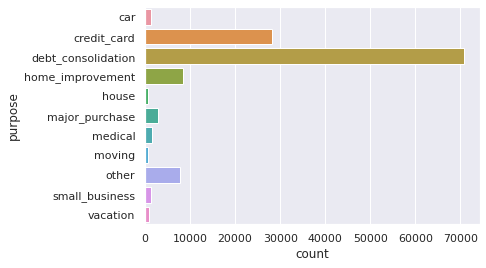

<AxesSubplot:xlabel='count', ylabel='emp_length'>

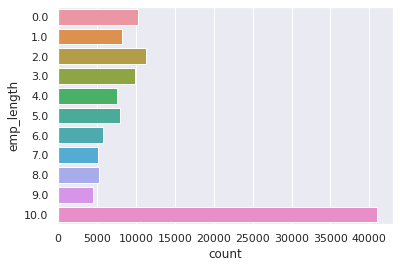

In [86]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [87]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

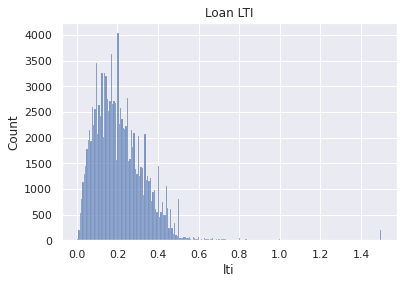

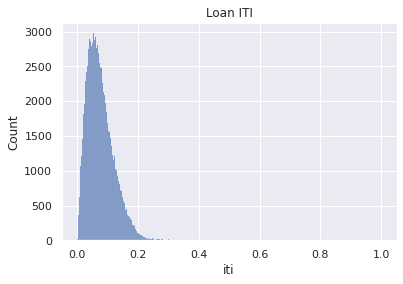

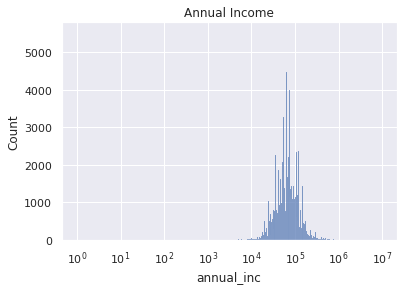

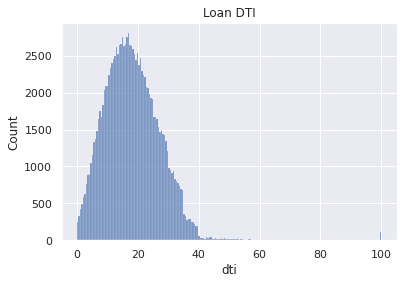

In [88]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [89]:
df.dti.describe()

count    124574.000000
mean         18.281853
std           9.280261
min           0.000000
25%          11.700000
50%          17.540001
75%          24.049999
max         100.000000
Name: dti, dtype: float64

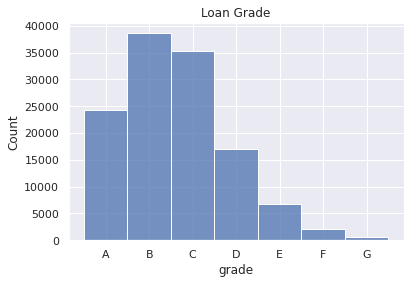

In [90]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

### EDA with target

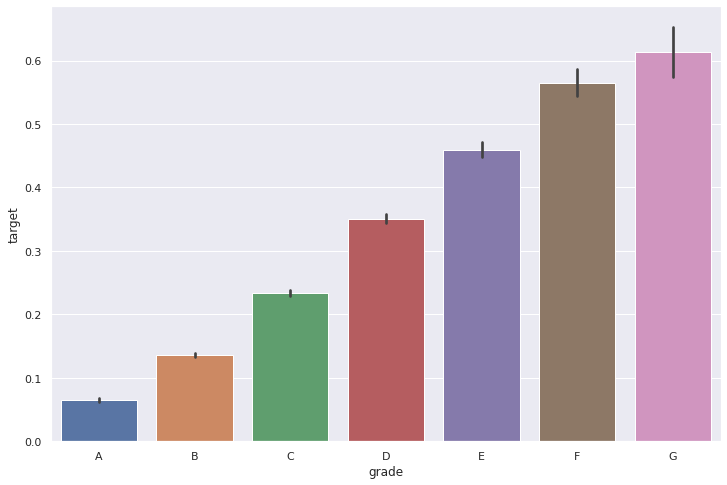

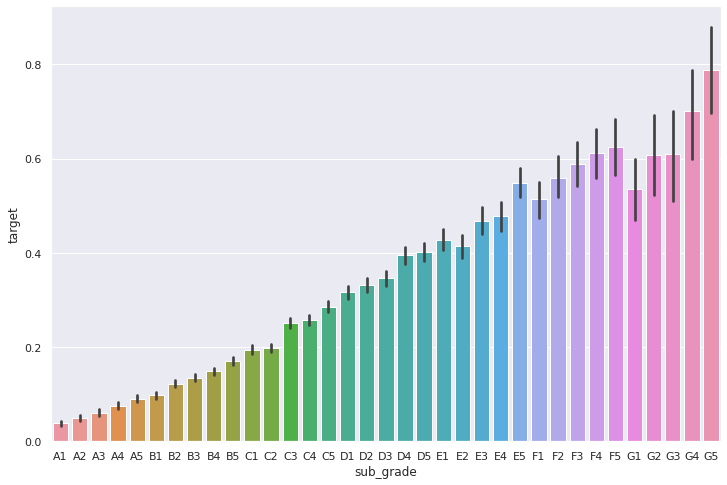

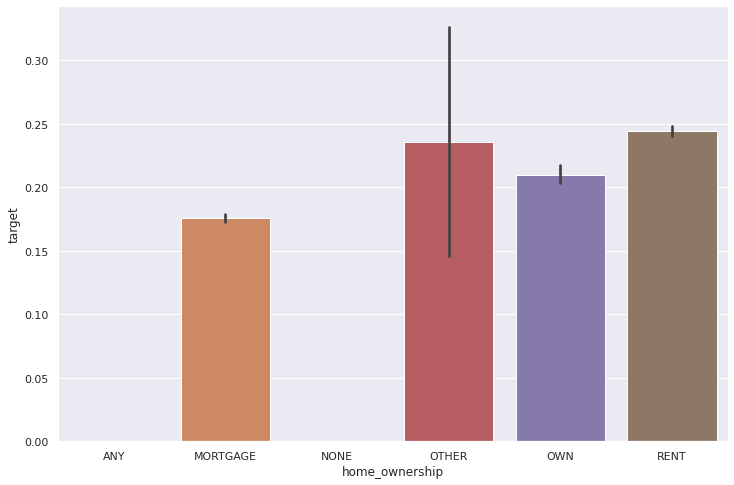

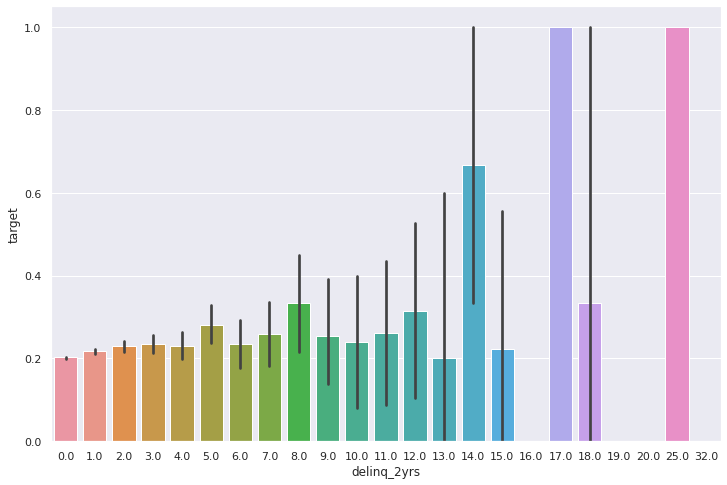

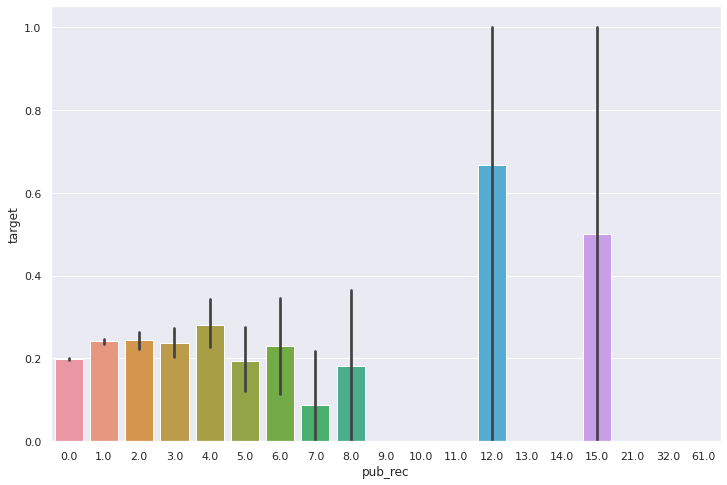

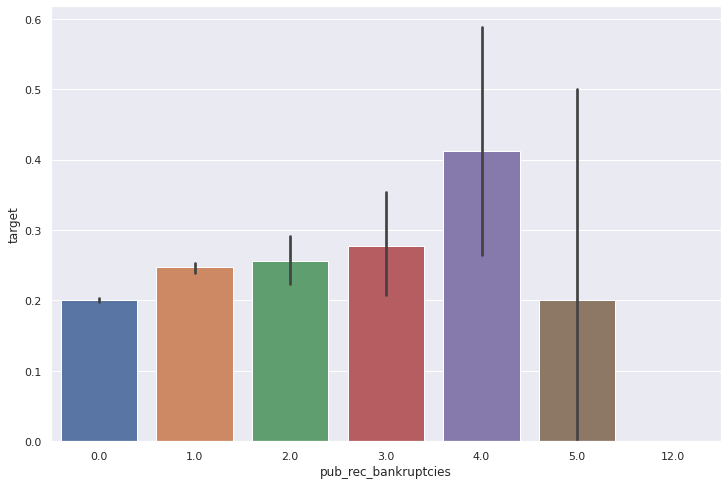

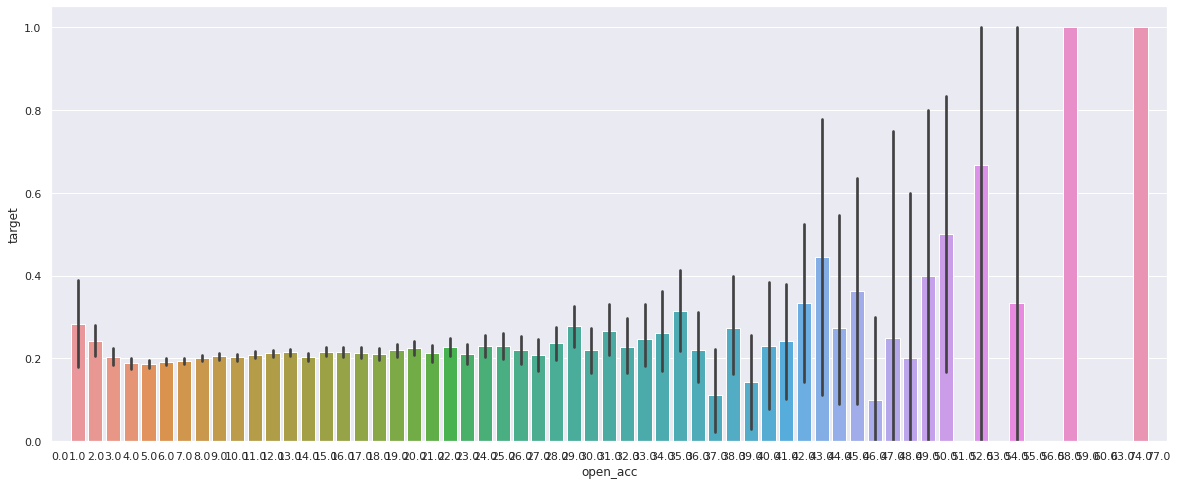

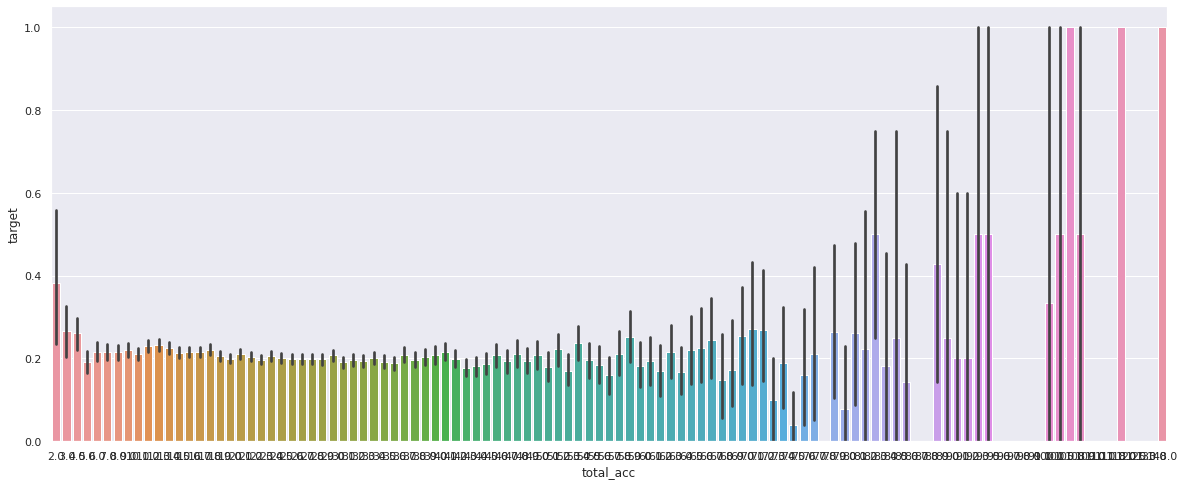

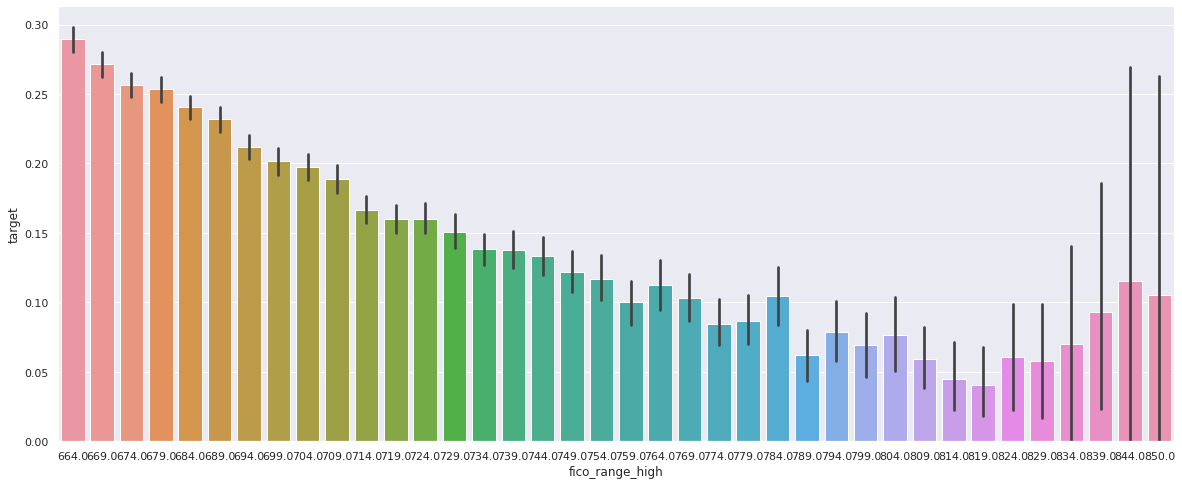

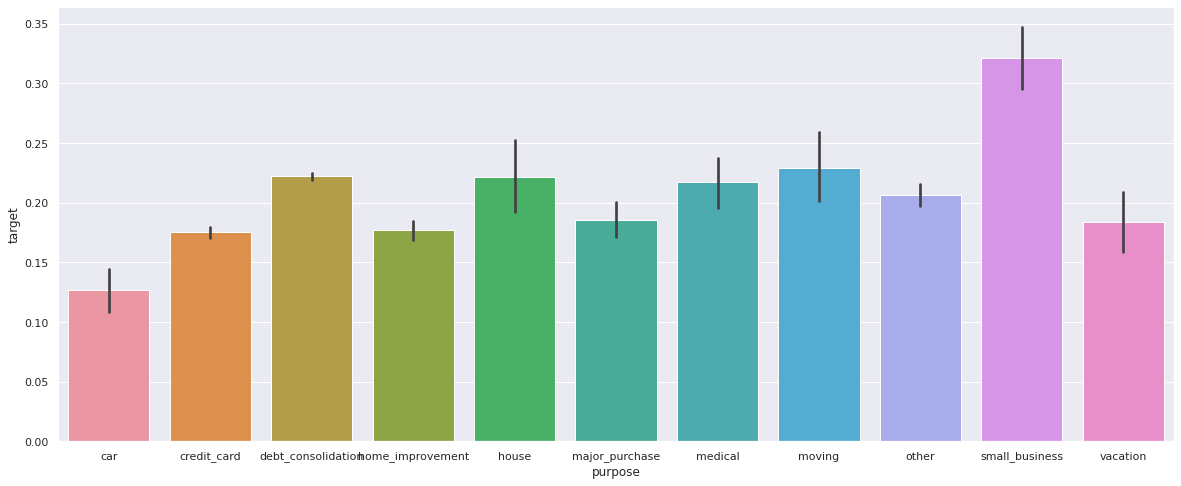

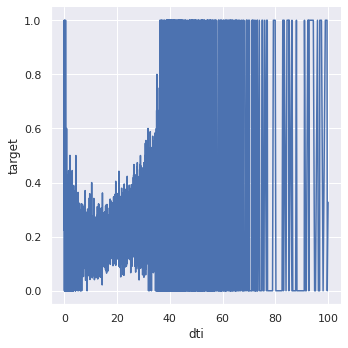

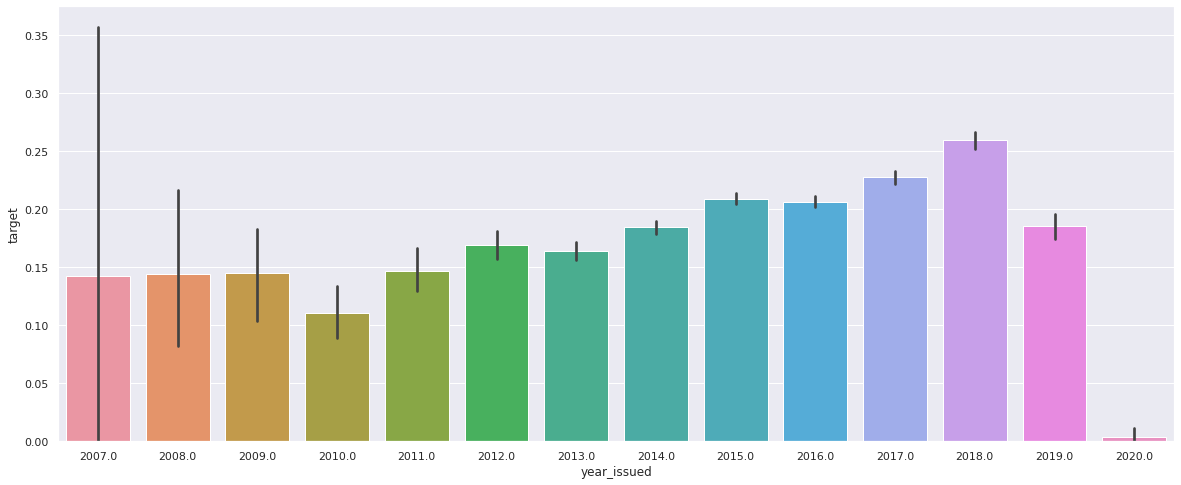

In [91]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

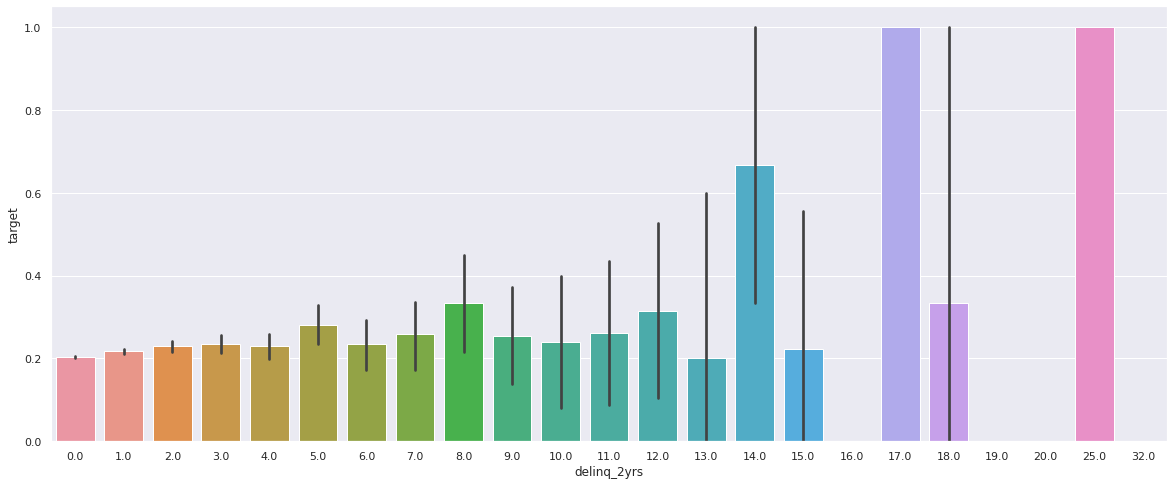

In [92]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

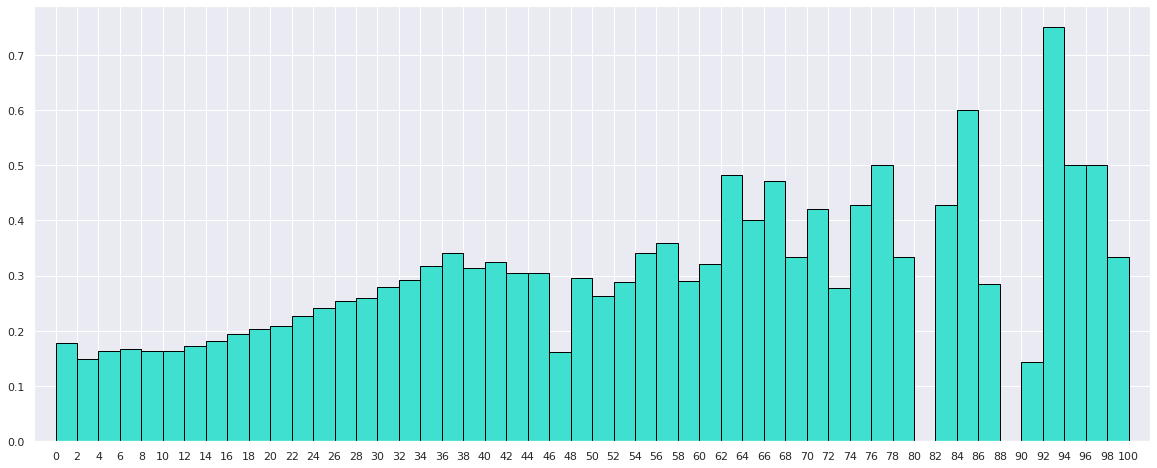

In [93]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### 5. Train-test split, missing values and feature engineering

In this section I fill missing values from train set and encode categorical features.

Depending of feature type, I use three encoding types:

- Target encoding. I do it for feature with more than 5 unique values.
- One-hot encoding. I use it for features with less than 5 unique values.
- Frequency encoding. 'Title' feature only.

In [94]:
display(df.count())

id                                124647
loan_amnt                         124647
funded_amnt                       124647
funded_amnt_inv                   124647
term                              124647
int_rate                          124647
installment                       124647
purpose                           124647
title                             123232
initial_list_status               124647
application_type                  124647
grade                             124647
sub_grade                         124647
fico_range_high                   124647
emp_title                         116004
emp_length                        116912
home_ownership                    124647
annual_inc                        124647
zip_code                          124647
addr_state                        124647
dti                               124574
verification_status               124647
mo_sin_rcnt_tl                    124647
mths_since_last_delinq            124647
mths_since_last_

In [95]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 
                     'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'bc_open_to_buy','tot_cur_bal_inc', 'total_rev_inc',
                    'total_bal_ex_mort_inc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 
                      'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_accts_ever_120_pd',
                     'acc_open_past_24mths']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')
    
test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
    
df['total_cur_bal'] = df.tot_cur_bal_inc.median()*df.annual_inc
df['total_rev_hi_lim'] = df.total_rev_inc.median()*df.annual_inc
df['total_bal_ex_mort'] = df.total_bal_ex_mort_inc.median()*df.annual_inc


display(train.count())

(93486, 77)

(31161, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,20000.0,20000.0,19900.0,36.0,12.69,670.900024,home_improvement,Home improvement,f,Individual,C,C2,699.0,Sr. Principal Design Engineer,10.0,MORTGAGE,130000.0,921,CA,9.000000,Source Verified,3.0,16.0,1200.0,1200.0,16.0,16.0,4.0,0.0,0.0,0.0,16.0,4.0,3.0,35.0,62927.0,880976.0,128768.0,47.5,17935.0,3.0,7.0,14.0,189400.0,2.0,0.0,0.0,0.0,0.0,128768.0,0.0,0.0,50.0,91.199997,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,10,2015,28.501612,0.0,0.0,0.153846,0.061929,0,0.990523,0.484054,6.776739,0.990523,1.456923,0,0.457143,0
1,20000.0,20000.0,20000.0,36.0,20.31,746.440002,debt_consolidation,Debt Consolidatoin,f,Individual,D,D5,674.0,Dell Government Services,5.0,MORTGAGE,70000.0,300,GA,17.969999,Source Verified,3.0,80.0,1200.0,1200.0,80.0,80.0,2.0,2.0,0.0,0.0,21.0,5.0,2.0,41.0,12286.0,159712.0,16701.0,75.6,606.0,3.0,7.0,8.0,22087.0,0.0,0.0,0.0,0.0,0.0,50652.0,0.0,0.0,100.0,97.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,8,2013,11.915371,0.0,0.0,0.285714,0.127961,0,0.238586,0.175514,2.281600,0.723600,0.315529,0,0.512195,0
2,6750.0,6750.0,6750.0,36.0,6.62,207.250000,debt_consolidation,credit card loan,f,Individual,A,A2,739.0,AXA,4.0,MORTGAGE,150000.0,900,CA,3.510000,Not Verified,0.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,8.0,6.0,1.0,11.0,41672.0,291702.0,5639.0,35.2,10361.0,0.0,1.0,6.0,16000.0,0.0,0.0,0.0,0.0,0.0,9321.0,0.0,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2012.0,11,2012,6.338255,0.0,0.0,0.045000,0.016580,0,0.037593,0.277813,1.944680,0.062140,0.106667,0,0.727273,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,20000.0,20000.0,10468.860352,36.0,14.82,691.549988,debt_consolidation,chrisalcott,f,Individual,E,E3,694.0,Eagle Alliance,8.0,MORTGAGE,90000.0,216,MD,23.450001,Not Verified,120.0,28.0,1200.0,78.0,1200.0,1200.0,0.0,1.0,0.0,0.0,15.0,0.0,NaN,31.0,NaN,NaN,43868.0,47.8,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,3,2008,10.582011,0.094500,0.0,0.222222,0.092207,0,0.487422,NaN,NaN,NaN,NaN,0,0.483871,0
1,35000.0,35000.0,35000.000000,36.0,12.39,1169.040039,debt_consolidation,Debt consolidation,f,Individual,C,C1,774.0,VP Finance,10.0,MORTGAGE,110000.0,68,CT,25.790001,Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,13.0,3.0,1.0,21.0,7877.0,102403.0,32040.0,34.0,60600.0,3.0,6.0,8.0,94100.0,0.0,0.0,0.0,0.0,0.0,78506.0,0.0,0.0,14.300000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,12,2014,23.168169,0.000000,0.0,0.318182,0.127532,0,0.291273,0.071609,0.930936,0.713691,0.855455,0,0.619048,0
2,7200.0,7200.0,7200.000000,36.0,11.39,237.059998,home_improvement,Home improvement,w,Individual,B,B3,664.0,MISSING,0.0,MORTGAGE,58263.0,207,MD,23.770000,Not Verified,9.0,1200.0,1200.0,77.0,1200.0,1200.0,2.0,0.0,2.0,8.0,11.0,6.0,3.0,22.0,35175.0,386930.0,14433.0,61.9,5793.0,9.0,7.0,7.0,23300.0,0.0,0.0,0.0,2.0,2.0,28250.0,0.0,0.0,33.299999,100.0,2.0,0.0,0.0,0.0,0.0,0.0,2017.0,1,2017,33.254619,0.060142,1.0,0.123578,0.048825,0,0.247722,0.603728,6.641093,0.484870,0.399911,0,0.500000,1


loan_amnt                         93486
funded_amnt                       93486
funded_amnt_inv                   93486
term                              93486
int_rate                          93486
installment                       93486
purpose                           93486
title                             93486
initial_list_status               93486
application_type                  93486
grade                             93486
sub_grade                         93486
fico_range_high                   93486
emp_title                         93486
emp_length                        93486
home_ownership                    93486
annual_inc                        93486
zip_code                          93486
addr_state                        93486
dti                               93486
verification_status               93486
mo_sin_rcnt_tl                    93486
mths_since_last_delinq            93486
mths_since_last_major_derog       93486
mths_since_last_record            93486


In [96]:
train.percent_bc_gt_75.describe()

count    93486.000000
mean        42.687428
std         35.510754
min          0.000000
25%          0.000000
50%         40.000000
75%         66.699997
max        100.000000
Name: percent_bc_gt_75, dtype: float64

### Categorical features encoding

In [97]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

41.328086614608765

3.012852907180786

(93486, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,20000.0,20000.0,19900.0,36.0,12.69,670.900024,f,Individual,699.0,10.0,130000.0,9.000000,Source Verified,3.0,16.0,1200.0,1200.0,16.0,16.0,4.0,0.0,0.0,0.0,16.0,4.0,3.0,35.0,62927.0,880976.0,128768.0,47.5,17935.0,3.0,7.0,14.0,189400.0,2.0,0.0,0.0,0.0,0.0,128768.0,0.0,0.0,50.0,91.199997,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,10,2015,28.501612,0.0,0.0,0.153846,0.061929,0,0.990523,0.484054,6.776739,0.990523,1.456923,0,0.457143,0,0.060234,0.199825,0.206535,0.169341,0.174491,0.221540,0.208224,0.232069,0.174738
1,20000.0,20000.0,20000.0,36.0,20.31,746.440002,f,Individual,674.0,5.0,70000.0,17.969999,Source Verified,3.0,80.0,1200.0,1200.0,80.0,80.0,2.0,2.0,0.0,0.0,21.0,5.0,2.0,41.0,12286.0,159712.0,16701.0,75.6,606.0,3.0,7.0,8.0,22087.0,0.0,0.0,0.0,0.0,0.0,50652.0,0.0,0.0,100.0,97.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,8,2013,11.915371,0.0,0.0,0.285714,0.127961,0,0.238586,0.175514,2.281600,0.723600,0.315529,0,0.512195,0,0.000011,0.389766,0.206535,0.222920,0.206535,0.175061,0.184148,0.351412,0.174738
2,6750.0,6750.0,6750.0,36.0,6.62,207.250000,f,Individual,739.0,4.0,150000.0,3.510000,Not Verified,0.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,8.0,6.0,1.0,11.0,41672.0,291702.0,5639.0,35.2,10361.0,0.0,1.0,6.0,16000.0,0.0,0.0,0.0,0.0,0.0,9321.0,0.0,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2012.0,11,2012,6.338255,0.0,0.0,0.045000,0.016580,0,0.037593,0.277813,1.944680,0.062140,0.106667,0,0.727273,0,0.000139,0.051384,0.206535,0.222920,0.253268,0.213147,0.208224,0.064979,0.174738
3,28200.0,28200.0,28200.0,60.0,18.99,731.369995,f,Individual,734.0,0.0,95000.0,18.059999,Verified,3.0,78.0,78.0,1200.0,78.0,78.0,6.0,1.0,1.0,4.0,22.0,11.0,5.0,48.0,28884.0,635455.0,12926.0,12.1,33231.0,3.0,3.0,17.0,106600.0,0.0,0.0,0.0,0.0,0.0,55834.0,0.0,0.0,0.0,89.099998,4.0,2.0,0.0,0.0,0.0,2.0,2016.0,10,2016,35.663977,0.0,0.0,0.296842,0.092384,0,0.136063,0.304042,6.689000,0.587726,1.122105,0,0.458333,0,0.019736,0.350963,0.289676,0.181969,0.191944,0.109874,0.226454,0.351412,0.174738
4,20000.0,20000.0,20000.0,36.0,13.67,680.359985,f,Individual,694.0,4.0,65000.0,10.340000,Source Verified,6.0,67.0,67.0,1200.0,67.0,67.0,1.0,0.0,2.0,1.0,7.0,6.0,0.0,18.0,2175.0,15224.0,6624.0,26.8,12614.0,21.0,3.0,6.0,24700.0,0.0,0.0,0.0,0.0,0.0,15224.0,0.0,0.0,0.0,100.000000,0.0,1.0,0.0,0.0,0.0,3.0,2016.0,3,2016,8.164439,0.0,1.0,0.307692,0.125605,0,0.101908,0.033462,0.234215,0.234215,0.380000,0,0.388889,0,0.011670,0.244363,0.206535,0.317565,0.265763,0.196926,0.214944,0.232069,0.244264


loan_amnt                         93486
funded_amnt                       93486
funded_amnt_inv                   93486
term                              93486
int_rate                          93486
installment                       93486
initial_list_status               93486
application_type                  93486
fico_range_high                   93486
emp_length                        93486
annual_inc                        93486
dti                               93486
verification_status               93486
mo_sin_rcnt_tl                    93486
mths_since_last_delinq            93486
mths_since_last_major_derog       93486
mths_since_last_record            93486
mths_since_recent_bc_dlq          93486
mths_since_recent_revol_delinq    93486
num_tl_op_past_12m                93486
inq_last_6mths                    93486
inq_fi                            93486
inq_last_12m                      93486
open_acc                          93486
acc_open_past_24mths              93486


In [98]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
#X_train.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_train.columns]
#X_test.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_test.columns]

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()
X_test_0 = X_test.copy()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,20000.0,20000.0,10468.860352,36.0,14.82,691.549988,f,Individual,694.0,8.0,90000.0,23.450001,Not Verified,120.0,28.0,1200.0,78.0,1200.0,1200.0,0.0,1.0,0.0,0.0,15.0,0.0,1.0,31.0,NaN,NaN,43868.0,47.8,5250.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,40.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,3,2008,10.582011,0.094500,0.222222,0.092207,0,0.487422,NaN,1.265809,0.563015,0.384211,0,0.483871,0,0.000000,0.454606,0.205507,0.222016,0.205507,0.179291,0.217940,0.456989,0.174699
1,35000.0,35000.0,35000.000000,36.0,12.39,1169.040039,f,Individual,774.0,10.0,110000.0,25.790001,Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,13.0,3.0,1.0,21.0,7877.0,102403.0,32040.0,34.0,60600.0,3.0,6.0,8.0,94100.0,0.0,0.0,0.0,0.0,0.0,78506.0,0.0,0.0,14.300000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,12,2014,23.168169,0.000000,0.318182,0.127532,0,0.291273,0.071609,0.930936,0.713691,0.855455,0,0.619048,0,0.501391,0.195806,0.202804,0.222016,0.228034,0.191598,0.205110,0.233076,0.174699
2,7200.0,7200.0,7200.000000,36.0,11.39,237.059998,w,Individual,664.0,0.0,58263.0,23.770000,Not Verified,9.0,1200.0,1200.0,77.0,1200.0,1200.0,2.0,0.0,2.0,8.0,11.0,6.0,3.0,22.0,35175.0,386930.0,14433.0,61.9,5793.0,9.0,7.0,7.0,23300.0,0.0,0.0,0.0,2.0,2.0,28250.0,0.0,0.0,33.299999,100.0,2.0,0.0,0.0,0.0,0.0,0.0,2017.0,1,2017,33.254619,0.060142,0.123578,0.048825,0,0.247722,0.603728,6.641093,0.484870,0.399911,0,0.500000,1,0.060234,0.136000,0.285358,0.172854,0.178726,0.240887,0.217940,0.135141,0.174699
3,22000.0,22000.0,22000.000000,36.0,6.62,675.489990,f,Individual,714.0,3.0,89000.0,13.880000,Source Verified,15.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12.0,1.0,0.0,33.0,1964.0,23570.0,20398.0,57.5,15102.0,15.0,4.0,8.0,35500.0,0.0,0.0,0.0,0.0,0.0,23570.0,0.0,0.0,50.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,3,2014,14.330205,0.000000,0.247191,0.091077,0,0.229191,0.022067,0.264831,0.264831,0.398876,0,0.363636,0,0.200736,0.050023,0.205507,0.173219,0.177790,0.228025,0.230562,0.065462,0.244038
4,9000.0,9000.0,9000.000000,36.0,14.65,310.450012,f,Individual,679.0,1.0,47250.0,15.420000,Source Verified,4.0,19.0,1200.0,1200.0,1200.0,1200.0,5.0,1.0,0.0,0.0,19.0,7.0,0.0,23.0,4073.0,69243.0,9000.0,53.6,2800.0,4.0,4.0,8.0,16800.0,1.0,0.0,0.0,0.0,0.0,69243.0,0.0,0.0,75.000000,95.5,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,10,2015,12.000246,0.000000,0.190476,0.078844,0,0.190476,0.086201,1.465460,1.465460,0.355556,0,0.826087,0,0.501391,0.287601,0.238174,0.222016,0.228034,0.209971,0.205110,0.233076,0.244038


Number of features before transaformation:  (93486, 77)
time to do feature proprocessing:  3.455779552459717
Number of features after transaformation:  (93486, 79)


### 6. Modeling

Here I will build 2 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8547803949254433

'F1 score: '

0.5158690535625133

'ROCAUC: '

0.6774909901529925

'PRAUC: '

0.708947929430793

'R20P: '

0.9163090128755365

'Test Accuracy: '

0.8070023426719296

'F1 score: '

0.34186911796892094

'ROCAUC: '

0.5983389323222218

'PRAUC: '

0.4675331668655064

'R20P: '

0.6160037878787878

2.652305841445923

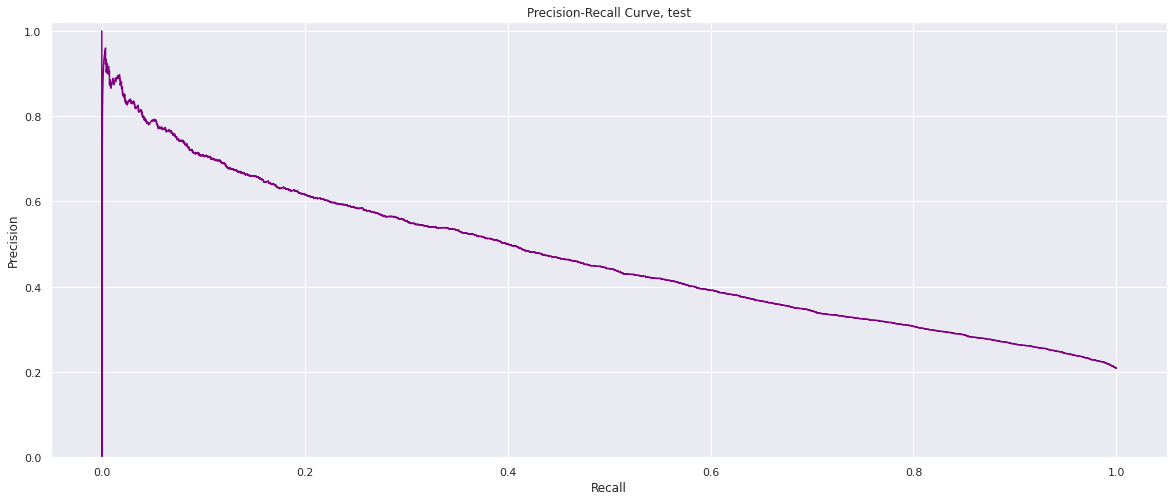

In [99]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-14 19:13:39,061] A new study created in memory with name: no-name-02bd136e-aea0-451c-b207-0ea2cdc336ae
[I 2022-08-14 19:13:42,707] Trial 0 finished with value: 0.4762465048062811 and parameters: {'n_estimators': 566, 'max_depth': 4, 'learning_rate': 0.10342834956796823, 'colsample_bytree': 0.11493000160165456, 'subsample': 0.7412036458536437, 'alpha': 0.4143131790383723, 'lambda': 52.87491730055603, 'gamma': 5.992532793183058, 'min_child_weight': 0.40394815824592467}. Best is trial 0 with value: 0.4762465048062811.
[I 2022-08-14 19:14:02,793] Trial 1 finished with value: 0.4393934800885153 and parameters: {'n_estimators': 1437, 'max_depth': 6, 'learning_rate': 0.13475823723606037, 'colsample_bytree': 0.15992513324881247, 'subsample': 0.5337267033750908, 'alpha': 0.1097643925326933, 'lambda': 58.187545547585174, 'gamma': 0.016075163619892686, 'min_child_weight': 0.9429894679334573}. Best is trial 0 with value: 0.4762465048062811.
[I 2022-08-14 19:14:10,002] Trial 2 finished w

Total time for hypermarameter optimization  541.6396069526672
        n_estimators : 1411
           max_depth : 3
       learning_rate : 0.01695838720416782
    colsample_bytree : 0.7017803261375167
           subsample : 0.5991216486695621
               alpha : 5.96968501111755
              lambda : 0.9174656434540246
               gamma : 0.2515884315950115
    min_child_weight : 0.8112556054343374
best objective value : 0.48339543165374477


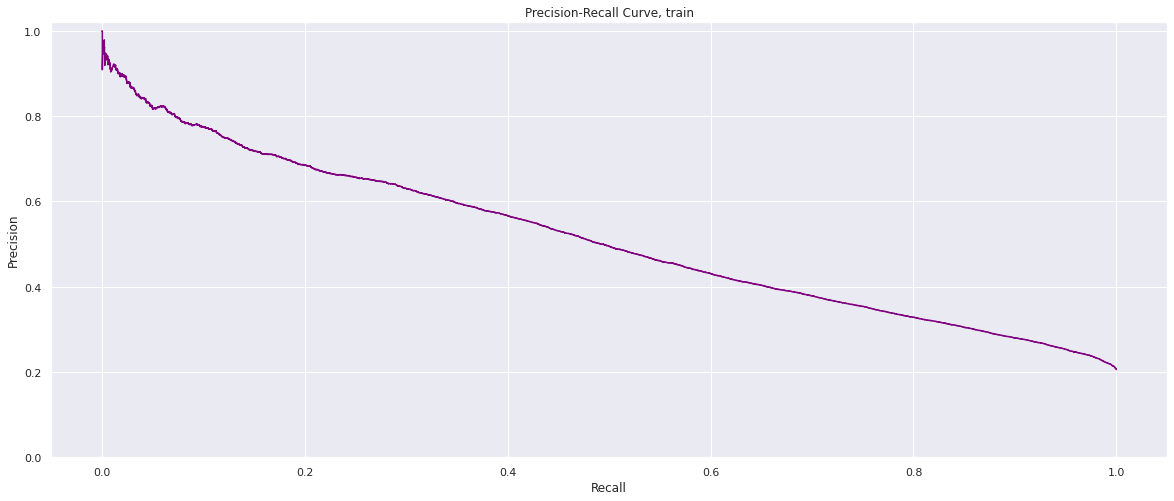

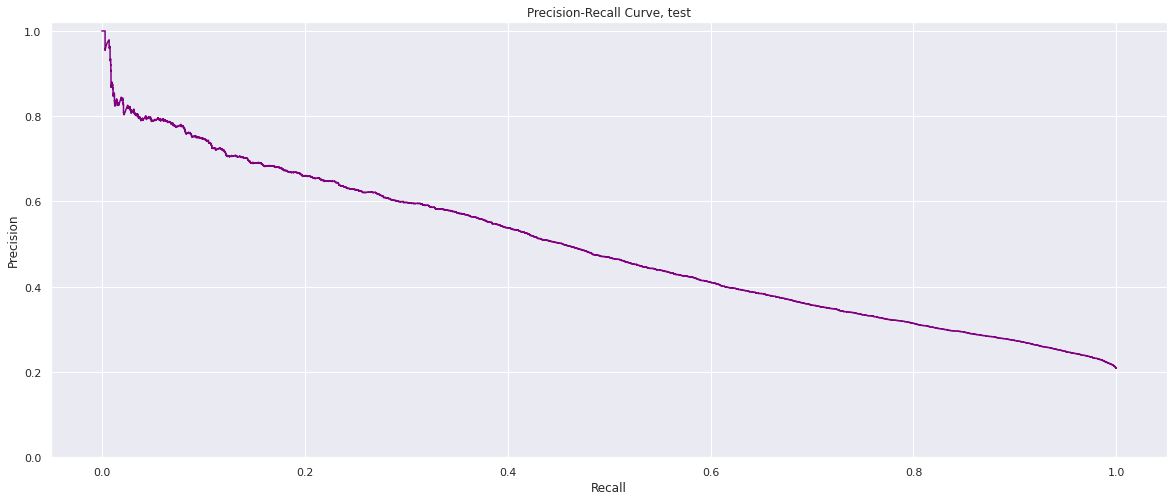

'Train Accuracy: '

0.8175127826626447

'F1 score: '

0.33489278752436646

'ROCAUC: '

0.5973527830178976

'PRAUC: '

0.5125932412552916

'R20P: '

0.6856276747503567

'Test Accuracy: '

0.8123936972497673

'F1 score: '

0.3244742315692165

'ROCAUC: '

0.592796850269339

'PRAUC: '

0.49063551409751105

'R20P: '

0.6602040816326531

'Time to do hyperparameter optimization: '

553.611834526062

In [100]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display('Time to do hyperparameter optimization: ', time.time()-time1)

### 7. Model interpretation

In [101]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

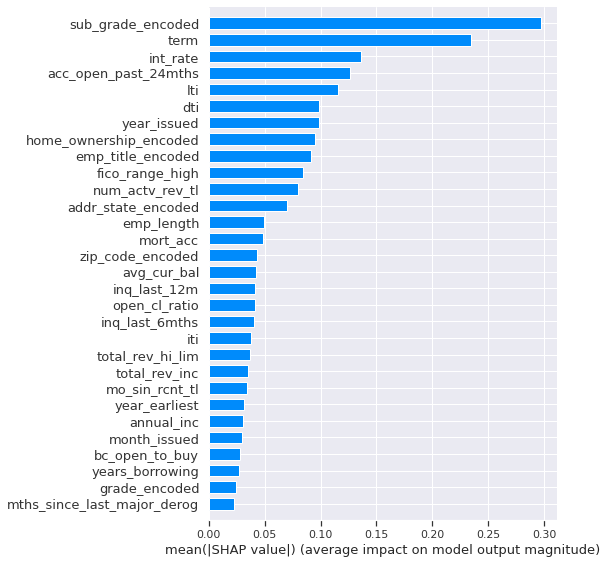

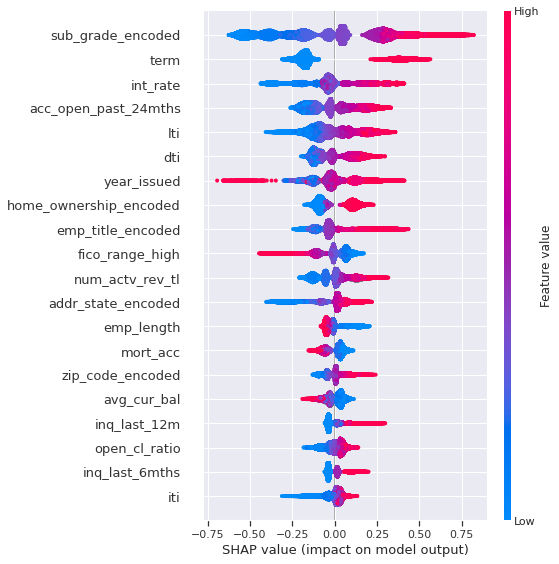

In [102]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [103]:
#indx = 1
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [104]:
time.time()-time0

613.3310368061066

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining and prediction problem, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 34%, which is not impressive. ROCAUC is 59% which is not much better than a random guess.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around one quarter of defaulted loans. For example, its precision at 20% recall is 69%. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 20% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

To quantify value created by the model, I consider a problem faced by all Lending Club investors as a group to maximize their investment profit. They can do so by avoiding x% of the riskiest loans as determined by my model. In order to keep this analysis simple and accessible to wider audience I abstract away from time discounting, compund interest and present value calculations. All the calculations below assume simple interest.

The decision of an investor to avoid financing x% of the riskiest loans is a tradoeff between a foregone interest income and a credit loss. 

If investors invest in a loan:
- They receive interest income in the future as long as the borrower repays a loan.
- They suffer credit losses and receive only recovered amount if the borrower defaults.

So their total dollar return (TR) from investment is as follows:

$$ TR_{Invest} = \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k.$$

Their outisde riskless option is to invest in Treasury bills with similar maturity. Average yield of 3-year treasury notes over this sample period [is around 2%](https://fred.stlouisfed.org/series/DGS3). So their TR if they forgo such loans is:

$$ TR_{Forgo} = \sum_{i \in AllLoans} LoanAmount_i*(1.02).$$

Thus the decision to issue such loans depends on which part dominates. Savings of investors from avoiding top x% riskiest loans are the difference between the returns fom investing in T-notes and LendingClub loans:

$$ \sum_{i \in AllLoans} LoanAmount_i*(1.02) - \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k $$

The expression above is the value created from avoiding the riskiest loans. For example, if I use the model to identify top 20% riskiest loans, then AllLoans will be the loans with 20% of the highest predicted default probabilities. RepaidLoans and DefaultedLoans will be subsets of those loans.

The code below uses loan_amnt, int_rate and recovery features to calculate this value created:



In [128]:
recoveries['total_recovery'] = recoveries.total_rec_prncp + recoveries.total_rec_int + recoveries.recoveries
recoveries['tot_recov_rp'] = recoveries.total_recovery/recoveries.loan_amnt
recoveries['tot_recov_rt'] = recoveries.total_recovery/(recoveries.loan_amnt*((recoveries.int_rate/100+1)**3))
# in a few cases the recoveries seem to exceed total proceeds.
# this may be the result of ignoring time discounting and compound interest in my calculations
# ior those may be rarer 60-months loans. so i do not adjust such cases.
display(recoveries.describe(), recoveries.head())

,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
count,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000
mean,1367.722534,15871.564453,15.650086,4618.821777,2792.090820,8778.634766,0.562341,0.368011
std,2009.665771,9072.825195,5.027926,4380.201660,2847.963135,7124.014648,0.293171,0.196640
min,0.000000,1000.000000,5.310000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9300.000000,11.990000,1586.069946,873.750000,3684.020020,0.333000,0.212242
50%,720.330017,14600.000000,14.990000,3291.959961,1856.170044,6859.430176,0.525157,0.340963
75%,1896.729980,21000.000000,18.550000,6198.540039,3728.580078,11852.330078,0.769617,0.508548
max,39859.550781,40000.000000,30.990000,38694.070312,28005.960938,61740.929688,1.764027,1.090076


,id,loan_status,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
8,1071795,Charged Off,190.539993,5600.0,21.28,162.020004,294.940002,647.500000,0.115625,0.064816
21,1039153,Charged Off,9.200000,21000.0,12.42,10694.959961,3330.439941,14034.600586,0.668314,0.470381
24,1069559,Charged Off,275.019989,6000.0,11.71,1305.579956,475.250000,2055.849854,0.342642,0.245790
27,1069657,Charged Off,263.000000,5000.0,16.77,629.049988,719.109985,1611.159912,0.322232,0.202383
50,1069248,Charged Off,222.809998,15000.0,9.91,13556.450195,2374.340088,16153.599609,1.076907,0.811085


In [186]:
X_test = X_test_0.copy()
test = X_test[['loan_amnt', 'int_rate']]
test.int_rate = test.int_rate/100+1
test['y_pred'] = optuna_xgb.predict_proba(X_test)[:,1]
test['id'] = test00.id
test['y'] = y_test
test = pd.merge(test, recoveries[['id', 'loan_amnt', 'int_rate', 'total_recovery']], on='id', how = 'left')
display(recoveries.head(), test.head())
display(test.loc[test.y==0].count(), test.loc[test.y==1].count())

,id,loan_status,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
8,1071795,Charged Off,190.539993,5600.0,21.28,162.020004,294.940002,647.500000,0.115625,0.064816
21,1039153,Charged Off,9.200000,21000.0,12.42,10694.959961,3330.439941,14034.600586,0.668314,0.470381
24,1069559,Charged Off,275.019989,6000.0,11.71,1305.579956,475.250000,2055.849854,0.342642,0.245790
27,1069657,Charged Off,263.000000,5000.0,16.77,629.049988,719.109985,1611.159912,0.322232,0.202383
50,1069248,Charged Off,222.809998,15000.0,9.91,13556.450195,2374.340088,16153.599609,1.076907,0.811085


,loan_amnt_x,int_rate_x,y_pred,id,y,loan_amnt_y,int_rate_y,total_recovery
0,20000.0,1.1482,0.184687,288720,0.0,NaN,NaN,NaN
1,35000.0,1.1239,0.091725,37077812,0.0,NaN,NaN,NaN
2,7200.0,1.1139,0.221871,96537467,1.0,7200.0,11.39,5384.810059
3,22000.0,1.0662,0.035813,12677422,0.0,NaN,NaN,NaN
4,9000.0,1.1465,0.285252,63477811,0.0,NaN,NaN,NaN


loan_amnt_x       24660
int_rate_x        24660
y_pred            24660
id                24660
y                 24660
loan_amnt_y           0
int_rate_y            0
total_recovery        0
dtype: int64

loan_amnt_x       6501
int_rate_x        6501
y_pred            6501
id                6501
y                 6501
loan_amnt_y       6501
int_rate_y        6501
total_recovery    6501
dtype: int64

In [201]:
# select top 20% riskiest loans by calculating decision threshold, giving 20% recall:

desired_recall = 0.205

temp = recall_t[(recall_t>(desired_recall-0.001))&(recall_t<(desired_recall+0.001))]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20threshold = threshold[indexx]
p80risk = r20threshold
test['p80risk'] = (test.y_pred>=p80risk).astype(int)
display(test.shape, p80risk)

risky_loans = test[test.p80risk==1]
risky_loans.loc[risky_loans.total_recovery.isnull(),'total_recovery']=\
risky_loans.loan_amnt_x*(risky_loans.int_rate_x**3)
# when the loan is repaid, I calculate total return and save it into total_recovery column.
display(risky_loans.head(), risky_loans.shape)

proceeds = risky_loans.total_recovery.sum()
proceeds_tnotes = (risky_loans.loan_amnt_x.sum())*(1.02**3)
print("Investors' total returns from investing in risky loans", int(proceeds))
print("Investors' total returns from investing in T-notes", int(proceeds_tnotes))
print("Investors' savings: $", int(proceeds_tnotes-proceeds))


(31161, 9)

0.5113434

,loan_amnt_x,int_rate_x,y_pred,id,y,loan_amnt_y,int_rate_y,total_recovery,p80risk
28,20000.0,1.2145,0.815766,125336203,1.0,20000.0,21.45,8864.990234,1
42,30000.0,1.1786,0.617273,46775274,1.0,30000.0,17.86,13227.429688,1
63,10625.0,1.2499,0.714390,75301082,1.0,10625.0,24.99,3385.540039,1
115,12075.0,1.2075,0.651688,75698771,0.0,NaN,NaN,21259.281250,1
130,18000.0,1.2484,0.739882,129614095,1.0,18000.0,24.84,7177.610352,1


(2024, 9)

Investors' total returns from investing in risky loans 37669632
Investors' total returns from investing in T-notes 42289961
Investors' savings: $ 4620329


In [144]:
test.describe()

,loan_amnt_x,int_rate_x,y_pred,y,loan_amnt_y,int_rate_y,total_recovery,p80risk
count,6233.000000,6233.000000,6233.000000,6233.000000,3050.000000,3050.000000,6233.000000,6233.0
mean,17749.578854,1.185083,0.470860,0.489331,17980.958984,19.045466,19523.263672,1.0
std,8769.674191,0.042356,0.134907,0.499926,8518.575195,4.425371,15590.164062,0.0
min,1000.000000,1.060000,0.309370,0.000000,1000.000000,7.390000,0.000000,1.0
25%,10900.000000,1.155900,0.358398,0.000000,11587.500000,15.990000,7300.410156,1.0
50%,16000.000000,1.179700,0.433884,0.000000,16087.500000,18.250000,15019.103516,1.0
75%,24000.000000,1.209900,0.556457,1.000000,24000.000000,21.850000,27813.697266,1.0
max,40000.000000,1.309900,0.921971,1.000000,40000.000000,30.990000,89491.875000,1.0


In [174]:
temp = y_test.to_frame()
temp['y_pred'] = optuna_xgb.predict_proba(X_test_0)[:,1]
temp[temp.y_pred>0.517].describe()

,target,y_pred
count,1965.000000,1965.000000
mean,0.660051,0.640268
std,0.473812,0.091259
min,0.000000,0.517076
25%,0.000000,0.562861
50%,1.000000,0.619650
75%,1.000000,0.704136
max,1.000000,0.921971


In [173]:
temp[temp.y_pred>0.517].describe()

AttributeError: 'numpy.float64' object has no attribute 'y_pred'

In [172]:
temp = recall_t[(recall_t>0.199)&(recall_t<0.201)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20threshold = threshold[indexx]
r20threshold

0.5168993